We are going to develop a Neural Network from Scratch which outputs if an image is a cat or not cat

Dataset: https://www.kaggle.com/datasets/muhammeddalkran/catvnoncat

In [1]:
!pip install opendatasets

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob #to make images as a list
import opendatasets as od #to import dataset
import h5py
from sklearn.model_selection import train_test_split

In [5]:
od.download("https://www.kaggle.com/datasets/muhammeddalkran/catvnoncat")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: madhav08
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/muhammeddalkran/catvnoncat


100%|██████████| 2.66M/2.66M [00:00<00:00, 79.7MB/s]

In [6]:
#opening HDF5 file
train_file_path = '/content/catvnoncat/catvnoncat/train_catvnoncat.h5'
train_dataset_x = 'train_set_x'
train_dataset_y = 'train_set_y'

with h5py.File(train_file_path,'r') as file:
  dataset_X = file[train_dataset_x]
  X_train = dataset_X[:]  # [:] loads the entire dataset into memory

  dataset_y = file[train_dataset_y]
  y_train = dataset_y[:]

  y_train = y_train.reshape(y_train.shape[0],1) #to not make it a rank 1 array

  print(f"X shape: {X_train.shape}")
  print(f"y shape: {y_train.shape}")

X shape: (209, 64, 64, 3)
y shape: (209, 1)


In [7]:
#now lets do the same thing for test variables
test_file_path = '/content/catvnoncat/catvnoncat/test_catvnoncat.h5'
test_dataset_x = 'test_set_x'
test_dataset_y = 'test_set_y'

with h5py.File(test_file_path,'r') as file:
  dataset_X = file[test_dataset_x]
  X_test = dataset_X[:]  # [:] loads the entire dataset into memory

  dataset_y = file[test_dataset_y]
  y_test = dataset_y[:]

  y_test = y_test.reshape(y_test.shape[0],1) #to not make it a rank 1 array

  print(f"X shape: {X_test.shape}")
  print(f"y shape: {y_test.shape}")

X shape: (50, 64, 64, 3)
y shape: (50, 1)


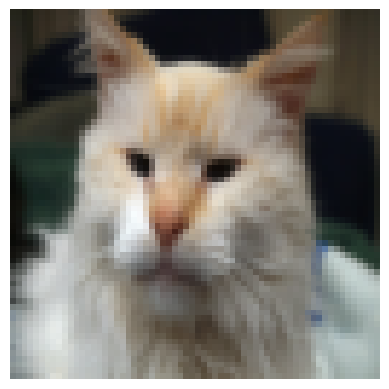

In [8]:
#so lets see the image for a random X_train
plt.imshow(X_train[27])
plt.axis('off')
plt.show()

Nice!

In [9]:
#first lets normalise the dataset
X_train = X_train/255
X_test = X_test/255

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (209, 64, 64, 3)
X_test shape: (50, 64, 64, 3)


NOW, lets build the neural network

In [10]:
#flatten the arrays
X_train = X_train.reshape(X_train.shape[0], -1).T
X_test = X_test.reshape(X_test.shape[0], -1).T
y_train = y_train.reshape(y_train.shape[0], -1).T
y_test = y_test.reshape(y_test.shape[0], -1).T
print(X_train.shape)
print(y_train.shape)

(12288, 209)
(1, 209)


Now, all the pixel values for a image is in a single column

I'm building a 2 layer Neural Network with 512 neurons in first layer and 256 in second

In [11]:
#initialising weights abd biases
def initialise_parameters(layer_dims):
  parameters = {}
  L = len(layer_dims)
  for l in range(1,L):
    parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) *  np.sqrt(2. / layer_dims[l-1])  #He initialisation
    parameters[f"b{l}"] = np.zeros((layer_dims[l],1))

  return parameters

So, in the next code block i'll be defining functions for activation functions
The activation functions im using for this particular dataset is ReLU and Sigmoid

ReLU is for all the hidden layers
and Sigmoid for the output layer as it is a binary classification problem (cat or not cat)

In [12]:
#Defining activation functions
def ReLU(Z):
  return np.maximum(0,Z)

def Sigmoid(Z):
  g = 1/(1+np.exp(-Z))
  return g

In [13]:
#forward propagation
def linear_forward(A,W,b):
  Z = np.dot(W,A) + b
  cache = (A,W,b)
  return Z, cache

def linear_forward_activation(A_prev, W, b, activation):
  Z, linear_cache = linear_forward(A_prev,W,b)
  activation_cache = (Z)
  if activation == "relu":
    A = ReLU(Z)
  elif activation == "sigmoid":
    A = Sigmoid(Z)

  cache = (linear_cache,activation_cache)
  return A, cache

In [14]:
#L-model Forward
def L_model_forward(X, parameters):
  caches = []
  A = X
  L = len(parameters)//2
  for l in range(1,L):
    A_prev = A
    A, cache = linear_forward_activation(A_prev, parameters[f"W{l}"], parameters[f"b{l}"], activation="relu")
    caches.append(cache)

  AL, cache = linear_forward_activation(A, parameters[f"W{L}"], parameters[f"b{L}"], activation="sigmoid")
  caches.append(cache)

  return AL, caches

In [15]:
#compute cost
def cost(AL, y):
  m = y.shape[1]
  AL = np.clip(AL, 1e-10, 1 - 1e-10)  # Prevents log(0)
  cost = (-1/m)*np.sum((np.multiply(y,np.log(AL))+np.multiply((1-y),np.log(1-AL))))
  cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
  return cost

In [16]:
#backward activation functions
def ReLU_backward(dA, activation_cache):
  Z = activation_cache
  dZ = np.array(dA,copy=True)
  dZ[Z<=0] = 0
  return dZ

def Sigmoid_backward(dA, activation_cache):
  Z = activation_cache
  A = Sigmoid(Z)
  dZ = dA * A * (1 - A)
  return dZ

In [17]:
#back propagation
def linear_backward(dZ, cache):
  A_prev, W, b = cache
  m = A_prev.shape[1]
  dW = (1/m)*np.dot(dZ,A_prev.T)
  db = (1/m)*np.sum(dZ, axis = 1, keepdims = True)
  dA_prev = np.dot(W.T,dZ)
  return dA_prev, dW, db

def linear_backward_activation(dA, cache, activation):
  linear_cache, activation_cache = cache
  if activation == "relu":
    dZ = ReLU_backward(dA,activation_cache)
    dA_prev, dW, db = linear_backward(dZ,linear_cache)
  elif activation == "sigmoid":
    dZ = Sigmoid_backward(dA,activation_cache)
    dA_prev, dW, db = linear_backward(dZ,linear_cache)

  return dA_prev, dW, db

In [18]:
#L-model Backward
def L_model_backward(AL, Y, caches):
  grads = {}
  L = len(caches) # the number of layers
  m = AL.shape[1]
  Y = Y.reshape(AL.shape) #to make Y the same shape as AL

  AL = np.clip(AL, 1e-10, 1 - 1e-10)  # Prevents AL/1-AL to not be 0

  dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

  current_cache = caches[L-1] #last layer
  dA_prev_temp, dW_temp, db_temp = linear_backward_activation(dAL, current_cache, activation="sigmoid")
  grads["dA" + str(L-1)] = dA_prev_temp
  grads["dW" + str(L)] = dW_temp
  grads["db" + str(L)] = db_temp

  for l in reversed(range(L-1)):
    current_cache = caches[l]
    dA_prev_temp, dW_temp, db_temp = linear_backward_activation(grads["dA" + str(l + 1)], current_cache, activation="relu")
    grads["dA" + str(l)] = dA_prev_temp
    grads["dW" + str(l + 1)] = dW_temp
    grads["db" + str(l + 1)] = db_temp

  return grads

In [19]:
#update parameters
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]

    return parameters

In [20]:
#combining into one model
def L_layer_model(X, Y, layer_dims, learning_rate = 0.001, num_iterations = 3000, print_cost=False):
  np.random.seed(1)
  costs = []
  parameters = initialise_parameters(layer_dims)

  for i in range(0,num_iterations):
    #forward prop
    AL, caches = L_model_forward(X, parameters)

    cost_value = cost(AL, Y)

    #backward prop
    grads = L_model_backward(AL, Y, caches)

    #update parameters
    parameters = update_parameters(parameters, grads, learning_rate)

    if i%100==0 or i == num_iterations-1:
      print(f"Cost after iteration {i}: {np.squeeze(cost_value)}")
    if i % 100 == 0 or i == num_iterations:
        costs.append(cost_value)

  return parameters, costs

Cost after iteration 0: 0.6802310724339663
Cost after iteration 100: 0.4768430939268268
Cost after iteration 200: 0.3492880787047853
Cost after iteration 300: 0.17639120457920432
Cost after iteration 400: 0.033965820391315016
Cost after iteration 500: 0.012927674431995514
Cost after iteration 600: 0.00817535994351066
Cost after iteration 700: 0.005850542957638183
Cost after iteration 800: 0.0044649589296217
Cost after iteration 900: 0.003552188241333965
Cost after iteration 1000: 0.002919721123211858
Cost after iteration 1100: 0.002463286901889038
Cost after iteration 1200: 0.0021158201228677195
Cost after iteration 1300: 0.001847307670875918
Cost after iteration 1400: 0.0016337052593917297
Cost after iteration 1500: 0.001461319152866325
Cost after iteration 1600: 0.0013187877190171814
Cost after iteration 1700: 0.0011990410240996644
Cost after iteration 1800: 0.001096993742411397
Cost after iteration 1900: 0.0010095260035396319
Cost after iteration 2000: 0.0009331807059798964
Cost aft

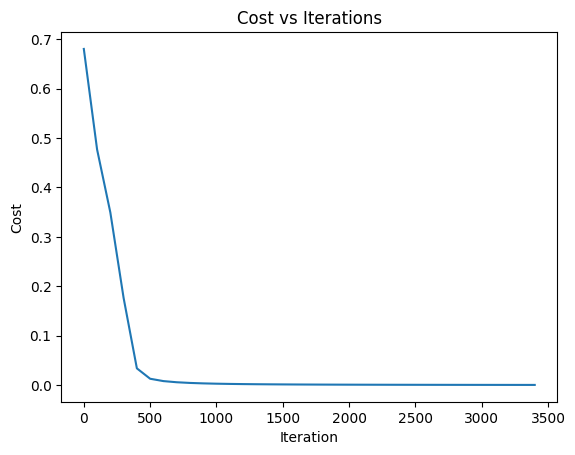

In [65]:
#training the model
#parameters
m_train = X_train.shape[1] #no.of training examples
n_h1 = 256 #number of neurons in hidden layer 1
n_h2 = 64 #number of neurons in hidden layer 2
n_x = X_train.shape[0] #no. of input features/pixels

layer_dims = [12288, n_h1, n_h2, 1]
num_iterations=3500

parameters, costs = L_layer_model(X_train, y_train, layer_dims, learning_rate=0.03, num_iterations=3500, print_cost=True)
plt.plot(range(0,num_iterations,100),costs)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs Iterations')
plt.show()

YAYYY 🥳! Our model training is over and the cost is good enough

In [67]:
#prediction function
def predict(X,parameters):
  m = X.shape[1]
  n = len(parameters) // 2 #no.of layers
  p = np.zeros((1,m))

  probabilities, cache = L_model_forward(X, parameters)
  for i in range(0, probabilities.shape[1]):
    if probabilities[0,i] > 0.9:
      p[0,i] = 1
    else:
      p[0,i] = 0

  return p, m

In [68]:
#testing the accuracy with test dataset
prediction_test, m = predict(X_test, parameters)
print("Accuracy: "  + str(np.sum((prediction_test == y_test)/m)))

Accuracy: 0.74


Tried a lot but couldnt improve than 74, if you can let me know

Now we try to predict using a photo of your own.

As we can't input image in terminal, we upload it as a temporary file in google colab and use the path to read the image as a numpy array (using matplotlib) and predict

We inputting a 64x64 image

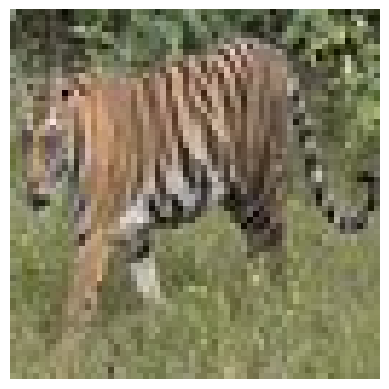

In [69]:
#test with your own image
path = "/content/Walking_tiger_female-2.jpg"
X_pred = plt.imread(path)

#printing image
plt.imshow(X_pred)
plt.axis('off')
plt.show()

In [70]:
#flatten the array
X_pred = X_pred.reshape(1, -1).T
X_pred = X_pred/255 #normalising as the image is jpg
print(X_pred.shape)

(12288, 1)


In [71]:
#predicting
prediction, m_pred = predict(X_pred, parameters)
print(np.squeeze(prediction))

0.0
